In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [2]:
#loading data

df = pd.read_csv('fraudTest.csv')

In [3]:
#feature engineering

df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], dayfirst=True)
df['hour'] = df['trans_date_trans_time'].dt.hour
df['dayofweek'] = df['trans_date_trans_time'].dt.dayofweek
df['dob'] = pd.to_datetime(df['dob'], dayfirst=True)
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

In [4]:
def haversine(lat1, lat2, long1, long2):
    lat1, lat2, long1, long2 = map(np.radians, [lat1, lat2, long1, long2])
    
    dlong = long2 - long1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371
    return c * r

df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

In [5]:
columnsToDrop = ['sn', 'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'city', 'zip', 'dob', 'trans_num', 'unix_time', 'lat', 'long', 'merch_lat', 'merch_long']
df_clean = df.drop(columns=columnsToDrop)
le = LabelEncoder()
for col in ['category', 'gender', 'state', 'job', 'merchant']:
    df_clean[col] = le.fit_transform(df_clean[col])

In [6]:
X = df_clean.drop(['is_fraud'], axis=1)
y = df_clean['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [7]:
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.25).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.89      0.79      0.83       429

    accuracy                           1.00    111144
   macro avg       0.94      0.89      0.92    111144
weighted avg       1.00      1.00      1.00    111144



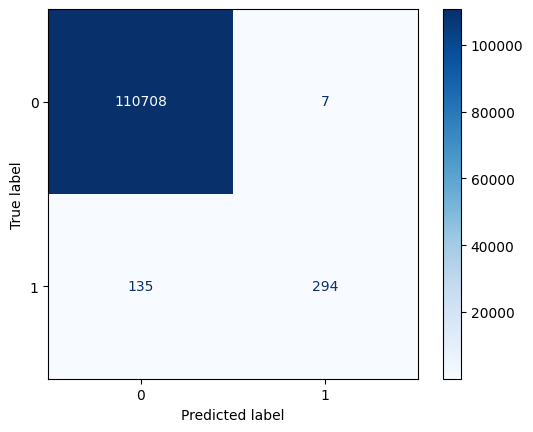

In [8]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.savefig('confusion_matrix.png')

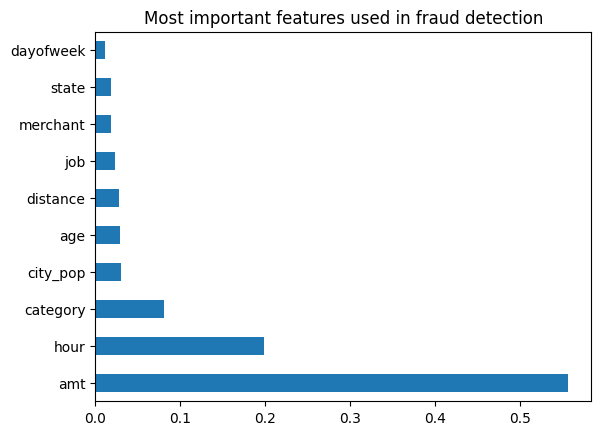

In [9]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Most important features used in fraud detection")
plt.savefig("feature_importance.png")